In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/train",
    shuffle=True,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 18345 files belonging to 10 classes.


In [3]:
dataset_valid = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/valid",
    shuffle=True,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4585 files belonging to 10 classes.


In [4]:
class_names = dataset_valid.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites',
 'Target_Spot',
 'Yellow_Leaf_Curl_Virus',
 'healthy',
 'mosaic_virus']

In [5]:
len(dataset_train)

574

In [6]:
len(dataset_valid)

144

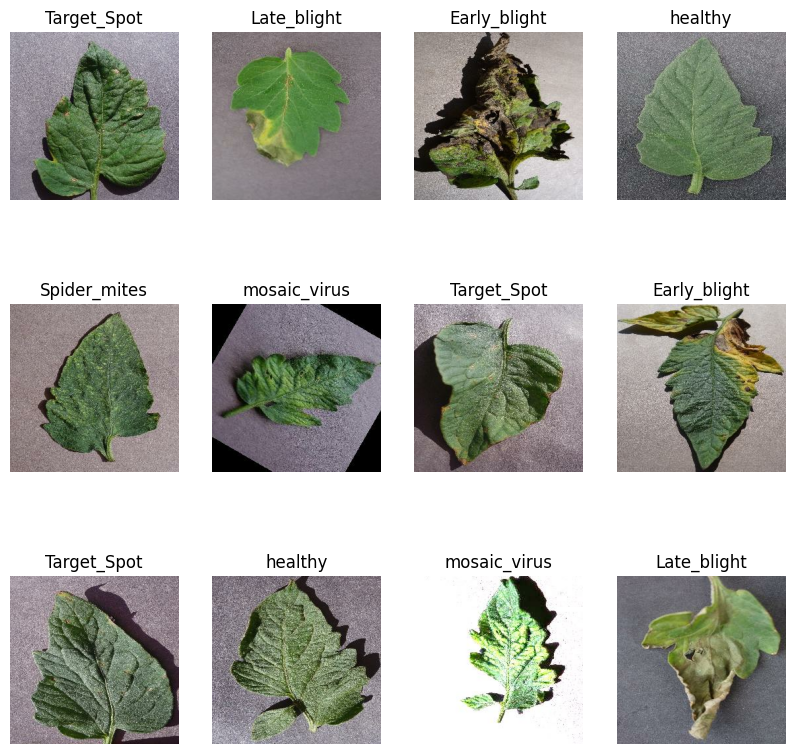

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset_train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [8]:
def get_dataset(dataset_train, dataset_valid, val_split=0.5, test_split = 0.5, shuffle = True, shuffle_size=10000):
    ds_size = len(dataset_valid)
    if shuffle:
        dataset_train = dataset_train.shuffle(shuffle_size, seed= 12)
        dataset_valid = dataset_valid.shuffle(shuffle_size, seed= 12)
    
    val_size = int(val_split*ds_size)
    val_ds=dataset_valid.take(val_size)
    test_ds = dataset_valid.skip(val_size)
    return dataset_train, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds = get_dataset(dataset_train, dataset_valid)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
CHANNELS = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(10, activation='softmax'),
])

model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [19]:
hist = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=valid_ds
)

574/574 [==============================] - 1485s 3s/step - loss: 0.0515 - accuracy: 0.9822 - val_loss: 0.0974 - val_accuracy: 0.9701


In [20]:
test_acc = model.evaluate(test_ds)
test_acc

72/72 [==============================] - 32s 445ms/step - loss: 0.1151 - accuracy: 0.9644


[0.1151009127497673, 0.9644097089767456]

In [21]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

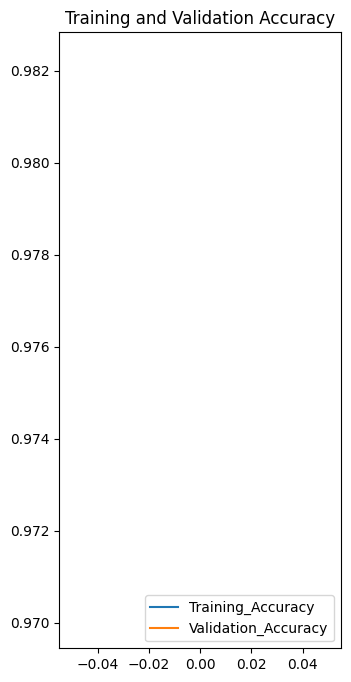

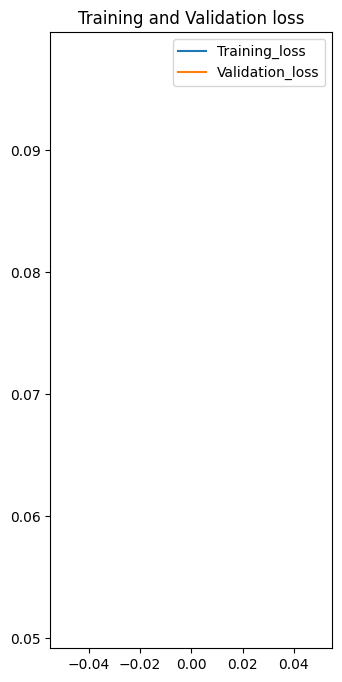

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1), acc, label='Training_Accuracy')
plt.plot(range(1), val_acc, label='Validation_Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1), loss, label='Training_loss')
plt.plot(range(1), val_loss, label='Validation_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

Actual the leaf is : Yellow_Leaf_Curl_Virus
1/1 [==============================] - 1s 701ms/step
Prediction of the image is : Yellow_Leaf_Curl_Virus


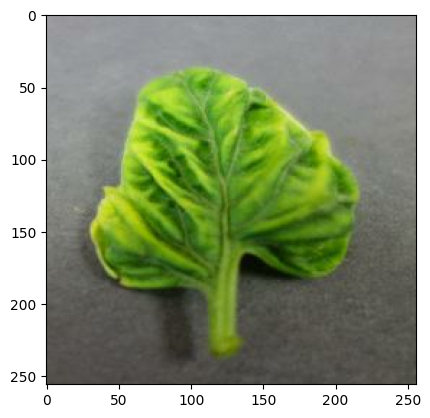

In [26]:
import numpy as np
for image_batch, labels_batch in dataset_train.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    print('Actual the leaf is :', class_names[first_label])
    prediction = model.predict(image_batch)
    print('Prediction of the image is :', class_names[np.argmax(prediction[0])])

In [27]:
def predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array = tf.expand_dims(image_array, 0)
    
    prediction = model.predict(image_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 142ms/step


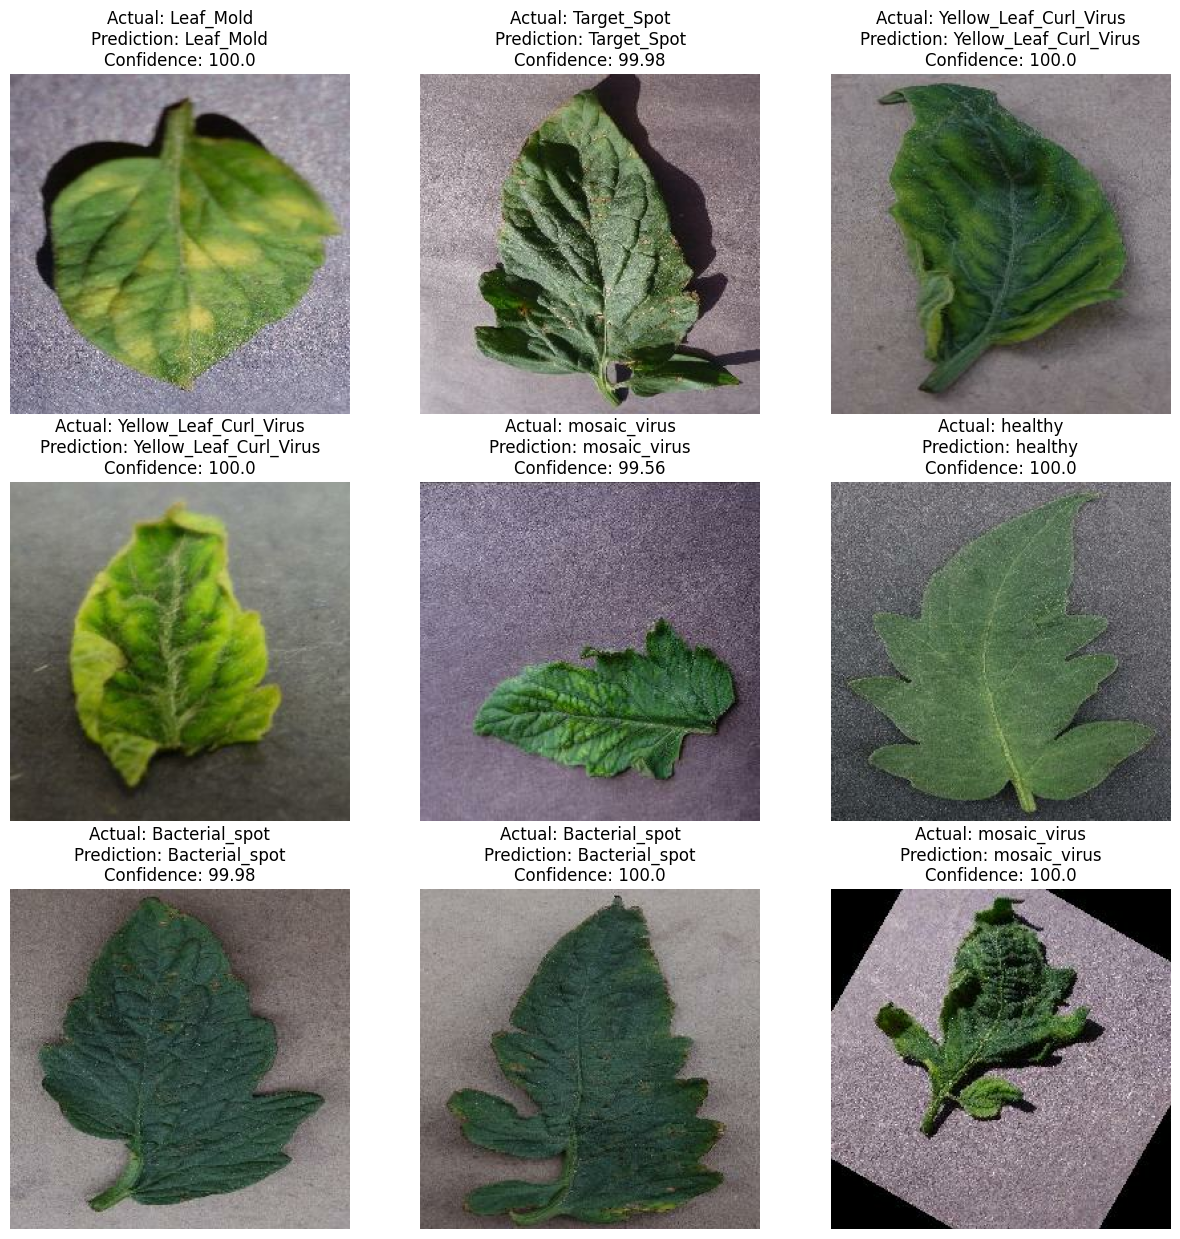

In [95]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        prediction_class, confidence = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\nPrediction: {prediction_class}\nConfidence: {confidence}")
        plt.axis('off')
    

In [30]:
import os
model_ver = max([int(i) for i in os.listdir("models") + [0]])+1
model_ver

5

In [ ]:
model.save(f'models/{model_ver}')

In [31]:
model.save('tomato.h5')